# MovIA: Proyecto desarrollo de un Sistema de Recomendación de Películas con IA

## Fase 1: Preparación del Entorno y Datos

In [22]:
# Importación de bibliotecas necesarias

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Lectura de los DataSets

df_credits = pd.read_csv('tmdb_5000_credits.csv')
df_movies = pd.read_csv('tmdb_5000_movies.csv')
print(df_credits.columns)
print(df_movies.columns)

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')
Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')


In [14]:
# Se cambia la columna 'movie_id' del DataFrame df_credits a 'id' para poder hacer un merge posteriormente
df_credits.columns = ['id', 'title', 'cast', 'crew']

# Se elimina la columna 'title' ya que está en ambos DataFrames y aparecería duplicada una vez se haga el merge
df_credits.drop(['title'], axis=1, inplace=True)
df_credits.head()

,id,cast,crew
0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [15]:
# Se hace el merge

df_merge = df_movies.merge(df_credits, on='id')
df_merge.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


## Fase 2: Análisis Exploratorio de Datos (EDA) y Procesamiento del Lenguaje Natural (NLP)

### EDA

In [28]:
df_merge.shape

(4803, 22)

In [20]:
df_merge.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [21]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

#### Revisión de nulos

In [25]:
# Cantidad de nulos

null_counts = df_merge.isnull().sum()
print("Número de valores nulos por columna:")
print(null_counts[null_counts > 0])

Número de valores nulos por columna:
homepage        3091
overview           3
release_date       1
runtime            2
tagline          844
dtype: int64


In [40]:
df_merge[df_merge['runtime'].isnull()]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",NaN,370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",it,Chiamatemi Francesco - Il Papa della gente,NaN,0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]",...,0,NaN,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,NaN,Chiamatemi Francesco - Il Papa della gente,7.3,12,"[{""cast_id"": 5, ""character"": ""Jorge Mario Berg...","[{""credit_id"": ""5660019ac3a36875f100252b"", ""de..."
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,"To Be Frank, Sinatra at 100",NaN,0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]",...,0,NaN,[],Released,NaN,"To Be Frank, Sinatra at 100",0.0,0,"[{""cast_id"": 0, ""character"": ""Narrator"", ""cred...","[{""credit_id"": ""592b25e4c3a368783e065a2f"", ""de..."


- *homepage*: Se eiminará dicha columna ya que tiene un alto contenido de nulos y no tiene información relevante para el objetivo del proyecto
- *overview*: Se eliminarás las filas con esos valores nulos ya que son muy pocos
- *release_date*: Se eliminarán las filas con esos valores nulos ya que son muy pocos
- *runtime*: Se reemplazarán las filas con esos valores nulos por la mediana
- *tagline*: Se reemplazarán los valores nulos por el texto 'Not available'

In [41]:
# Se elimina la columna 'homepage'
df_merge.drop(['homepage'], axis=1, inplace=True)

# Se eliminan las filas con valores nulos en 'overview' y 'release_date'
df_merge.dropna(subset=['overview', 'release_date'], inplace=True)

# Se reemplazan los valores nulos en 'runtime' con la mediana
median_runtime = df_merge['runtime'].median()
df_merge['runtime'].fillna(median_runtime, inplace=True)

# Se reemplazan los valores nulos en 'tagline' con 'Not available'
df_merge['tagline'].fillna('Not available', inplace=True)

In [42]:
# Verificación del tratamiento de nulos

null_counts = df_merge.isnull().sum()
print("Número de valores nulos por columna:")
print(null_counts[null_counts > 0])

Número de valores nulos por columna:
Series([], dtype: int64)


#### Valores atípicos

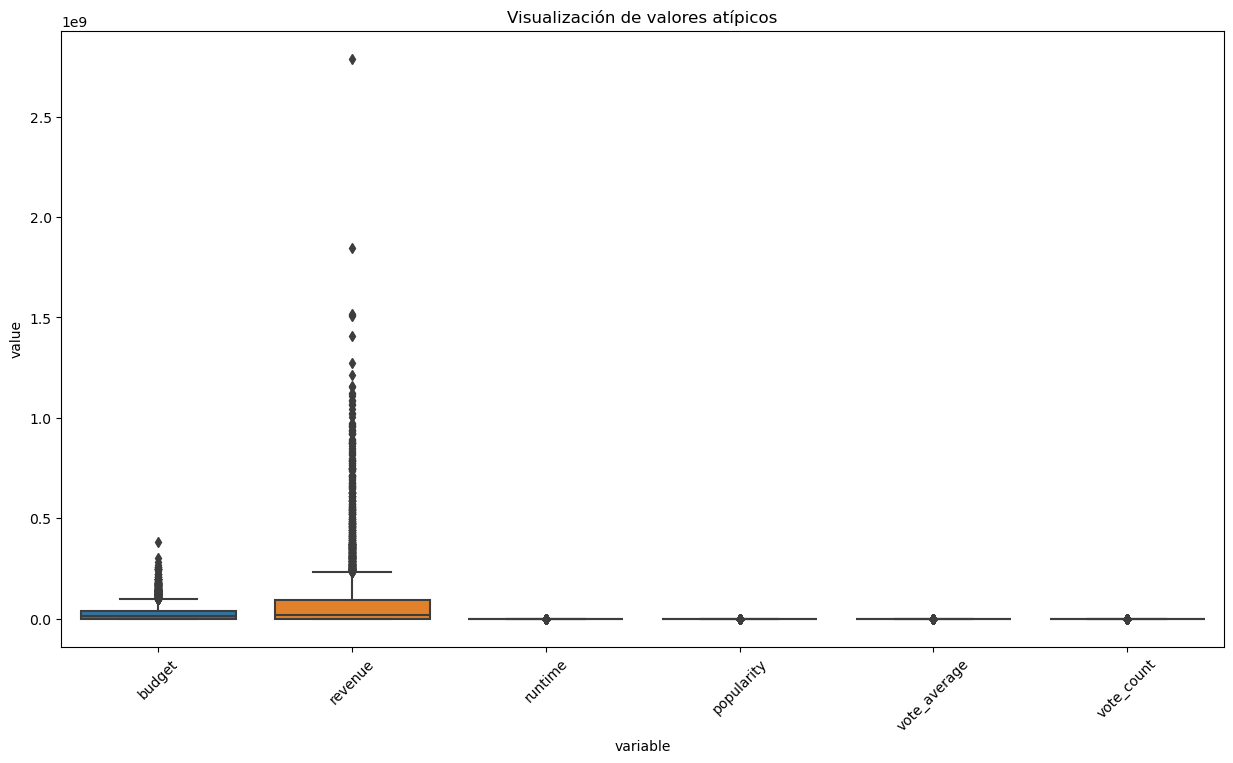

In [43]:
# Visualizar valores atípicos
plt.figure(figsize=(15, 8))
sns.boxplot(x="variable", y="value", data=pd.melt(df_merge[['budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count']]))
plt.title("Visualización de valores atípicos")
plt.xticks(rotation=45)
plt.show()

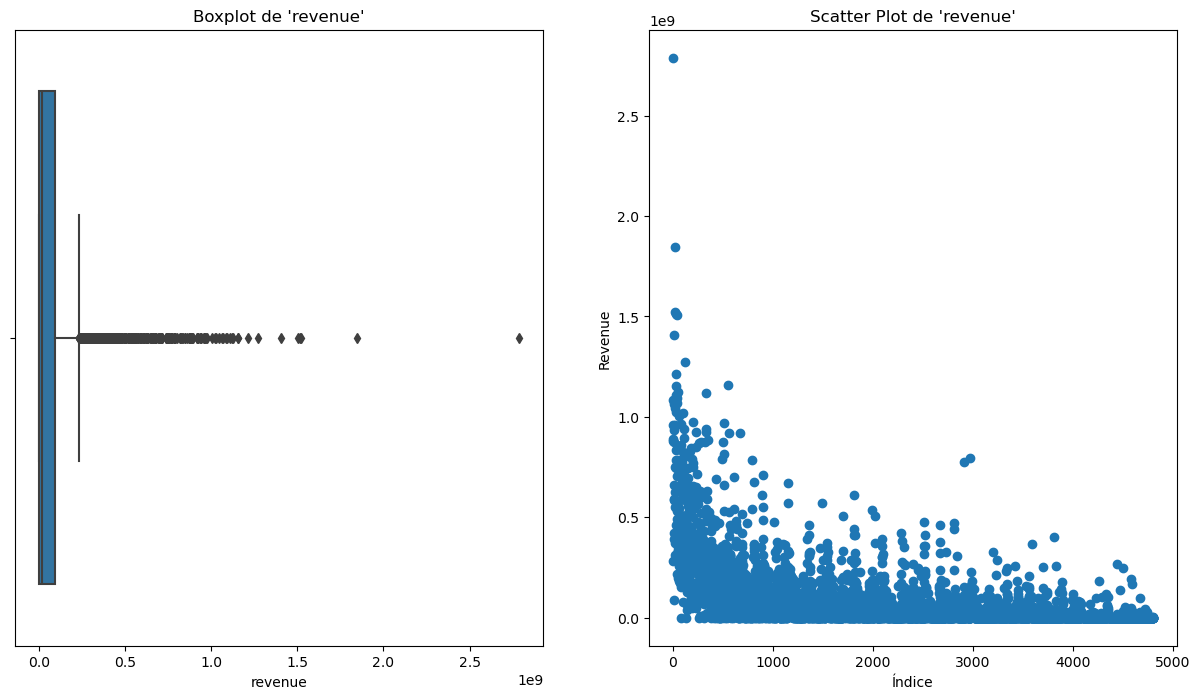

In [44]:
# Visualización con Boxplot y Scatter Plot para 'revenue'
plt.figure(figsize=(15, 8))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=df_merge['revenue'])
plt.title("Boxplot de 'revenue'")

# Scatter Plot
plt.subplot(1, 2, 2)
plt.scatter(x=df_merge.index, y=df_merge['revenue'])
plt.title("Scatter Plot de 'revenue'")
plt.xlabel("Índice")
plt.ylabel("Revenue")
plt.show()

Parece que en la variable 'revenue' hay un valor muy alto. Se va a analizar dicho registro:

In [50]:
revenue_max = df_merge['revenue'].max()

df_merge[df_merge['revenue'] == revenue_max]

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
